In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pathlib
# from jupyterthemes import jtplot
# jtplot.style()

In [25]:
def make_df(filename: str, use_ratio_for_approx=True):
    full_algos = ["direct"]
    approx_algos = ["tau_leaping", "tau_adaptive"]
    df  = pd.read_csv(filename, dtype={"model":str})
    df.loc[:, "nspecies"] = 1
    df.loc[df.model.isin(["00030", "00031"]), "nspecies"] = 2
    df.loc[:, "ntest"] = df.nspecies * 100 # number of tests
    # Number passing should be ntest
    full_inds = df.algo.isin(full_algos)
    approx_inds = df.algo.isin(approx_algos)
    if use_ratio_for_approx:
        df.loc[full_inds, "total_pass"] = (df[full_inds].ntest - 
                                           (df.loc[full_inds, "test0"] + 
                                            df.loc[full_inds, "test1"] + 
                                            df.loc[full_inds, "test2"] + 
                                            df.loc[full_inds, "test3"]))/df[full_inds].ntest * 100

        df.loc[approx_inds, "total_pass"] = (df[approx_inds].ntest - 
                                           (df.loc[approx_inds, "rtest0"] + 
                                            df.loc[approx_inds, "rtest1"] + 
                                            df.loc[approx_inds, "rtest2"] + 
                                            df.loc[approx_inds, "rtest3"]))/df[approx_inds].ntest * 100
    else:
        df.loc[:,"total_pass"] = (df.ntest - (df["test0"] + 
                                              df["test1"] + 
                                              df["test2"] + 
                                              df["test3"]))/df.ntest * 100
    # If test0 is -1 because test didn't ocmplete, then they should be labeled as such.
    df.loc[df["total_pass"] > df.ntest, "total_pass"] = -0.1
    return df

In [71]:
def make_benchmark_df():
    
    files = list(pathlib.Path("../benchmarks/").glob("*.json"))
    results = []
    for this_file in files:
        with open(this_file) as fid:
            data_dict = json.load(fid)
            # print(this_file.stem, data_dict)
            # print(this_file.stem, this_name)
            lib, algo, model, nreps = this_file.stem.split("-")
            # print(lib, algo, model, nreps, data_dict, type(data_dict))
            this_result = data_dict["results"][0]
            this_result["lib"] = lib
            this_result["algo"] = algo
            this_result["model"] = model
            this_result["nrep"] = int(nreps)
            results.append(this_result)

    # print(results)
    df = pd.DataFrame(results)
    df = df[df.nrep == 10000]
    return df

In [75]:
def make_benchmark_barplot(df):
    times = df.explode("times")
    sns.barplot(x="model", y="times", hue="lib", data=times)

In [77]:
pyssa_results = make_df("../results/pyssa_results.csv")
tellurium_results = make_df("../results/Tellurium_results.csv")
biosimulator_results = make_df("../results/BioSimulator_results.csv")
biosimulatorintp_results = make_df("../results/BioSimulatorIntp_results.csv")
gillespiessa_results = make_df("../results/GillespieSSA_results.csv")
benchmark_results = make_benchmark_df()

In [29]:
results = pd.concat([pyssa_results, tellurium_results, biosimulator_results, biosimulatorintp_results, 
                     gillespiessa_results])
results

,model,lib,algo,nrep,test0,test1,test2,test3,rtest0,rtest1,rtest2,rtest3,nspecies,ntest,total_pass
0,00004,pyssa,direct,10000,0,0,0,0,0,0,0,0,1,100,100.0
1,00004,pyssa,tau_adaptive,10000,0,0,0,3,0,0,0,10,1,100,90.0
2,00001,pyssa,direct,10000,0,0,0,0,0,0,0,0,1,100,100.0
3,00001,pyssa,tau_leaping,10000,0,0,0,0,0,0,0,0,1,100,100.0
4,00001,pyssa,tau_adaptive,10000,0,0,0,0,0,0,0,2,1,100,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,00037,GillespieSSA,tau_leaping,10000,50,0,50,0,50,0,50,0,1,100,0.0
24,00038,GillespieSSA,tau_adaptive,10000,50,0,50,0,50,0,50,0,1,100,0.0
25,00038,GillespieSSA,tau_leaping,10000,50,0,50,0,50,0,50,0,1,100,0.0
26,00039,GillespieSSA,tau_adaptive,10000,50,0,50,0,50,0,50,0,1,100,0.0


In [30]:
results[results.total_pass < 0]

,model,lib,algo,nrep,test0,test1,test2,test3,rtest0,rtest1,rtest2,rtest3,nspecies,ntest,total_pass


In [79]:
acc_speed_results = benchmark_results.merge(results, how="inner", on = ["lib", "algo", "model"])

In [80]:
acc_speed_results.head()

,command,mean,stddev,median,user,system,min,max,times,lib,...,test1,test2,test3,rtest0,rtest1,rtest2,rtest3,nspecies,ntest,total_pass
0,julia biosimjl_test/make_biosim_results.jl 000...,6.992687,0.252884,6.919580,6.703583,0.648562,6.830754,7.541846,"[7.54184570085, 6.83075350485, 6.85326590585, ...",BioSimulator,...,0,0,0,0,0,0,0,1,100,100.0
1,julia biosimjl_test/make_biosim_results.jl 000...,8.949872,0.072271,8.945051,8.329951,1.054672,8.874817,9.094799,"[8.87481668838, 8.94505102138, 9.0947985563799...",BioSimulator,...,0,0,5,0,12,1,9,1,100,95.0
2,julia biosimjl_test/make_biosim_results.jl 000...,7.037875,0.142517,6.961350,6.764233,0.695744,6.912390,7.311989,"[6.9613495557250005, 6.959481002725, 7.1365935...",BioSimulator,...,0,0,0,0,0,0,0,1,100,100.0
3,julia biosimjl_test/make_biosim_results.jl 000...,5.598100,0.093141,5.572237,5.592395,0.418798,5.487920,5.740631,"[5.551804434615, 5.487919591615, 5.57223690461...",BioSimulator,...,0,0,0,0,0,0,0,2,200,100.0
4,julia biosimjl_test/make_biosim_results.jl 000...,6.329847,0.085929,6.332444,6.202522,0.544836,6.216229,6.460468,"[6.460467532435, 6.343335806435, 6.40198515743...",BioSimulator,...,0,0,0,0,1,1,2,1,100,100.0


<Figure size 1080x720 with 0 Axes>

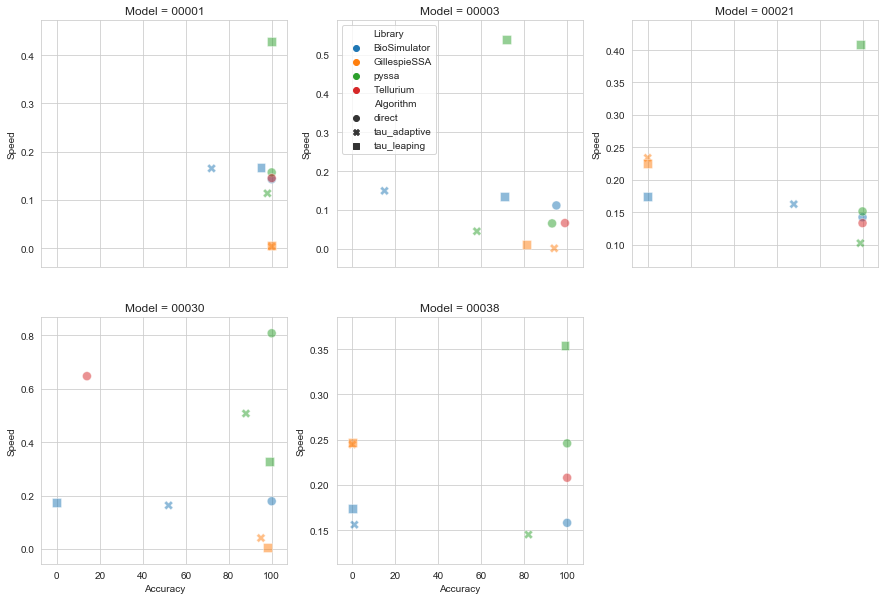

In [139]:
# plt.plot(acc_speed_results.total_pass, 1/acc_speed_results["mean"], ".")
# plt.xlabel("Accuracy")
# plt.ylabel("Speed")
acc_speed_results["Accuracy"] = acc_speed_results["total_pass"]
acc_speed_results["Speed"] = 1/acc_speed_results["mean"]
acc_speed_results["Library"] = acc_speed_results["lib"]
acc_speed_results["Algorithm"] = acc_speed_results["algo"]

# kws = dict(s=80)

# g = sns.FacetGrid(acc_speed_results, col="model", hue="Library", col_wrap=3, height=4, aspect=1)
# # g.scatterplot(x = "Accuracy", y="Speed", hue="Library", style = "Algorithm", data=acc_speed_results)
# g.map(plt.scatter, "Accuracy", "Speed", edgecolor="w", **kws).add_legend()
models = sorted(set(list(acc_speed_results.model)))
this_filter = (acc_speed_results.model == models[0])
marker_size = 80
plt.figure(figsize=([15,10]))
fig, ax = plt.subplots(2,3,sharex=True, figsize=([15,10]))
fig.delaxes(ax[1][2])

for ind, this_model in enumerate(models):
    this_filter = (acc_speed_results.model == this_model)
    this_ax = ax[ind//3, ind%3]
    this_ax.set_title(f"Model = {this_model}")
    sns.set_style("whitegrid")
    if ind == 1:
        sns.scatterplot(x="Accuracy", y="Speed", hue="Library", style="Algorithm", 
                        data=acc_speed_results[this_filter], s=marker_size,
                        ax = this_ax, alpha=0.5)
    else:
        sns.scatterplot(x="Accuracy", y="Speed", hue="Library", style="Algorithm", 
                        data=acc_speed_results[this_filter], s=marker_size,
                        ax = this_ax, legend=False, alpha=0.5)

In [136]:
acc_speed_results[(acc_speed_results["lib"] == "GillespieSSA") & (acc_speed_results["model"] == "00001")]

,command,mean,stddev,median,user,system,min,max,times,lib,...,rtest1,rtest2,rtest3,nspecies,ntest,total_pass,Accuracy,Speed,Library,Algorithm
15,Rscript GillespieSSA_test/make_gillespieSSA_re...,271.906726,1.442202,271.878335,263.895866,8.324570,270.081352,273.949386,"[273.00671765127, 270.50317862927, 271.8783353...",GillespieSSA,...,0,0,0,1,100,100.0,100.0,0.003678,GillespieSSA,tau_adaptive
20,Rscript GillespieSSA_test/make_gillespieSSA_re...,154.684626,0.925286,154.961899,149.964032,5.075857,153.280639,155.689135,"[155.68913488951, 154.50012075951, 153.2806389...",GillespieSSA,...,0,0,0,1,100,100.0,100.0,0.006465,GillespieSSA,tau_leaping


In [156]:
# TODO: Make it easy to distinguish between pass and fail
def plot_pass_bars(df, hue="algo"):
    plt.figure(figsize=(14,5))
    if hue == "lib":
        current_palette = sns.color_palette("Set1", n_colors=5)
        new_palette = {"pyssa":current_palette[1], "BioSimulator":current_palette[0],
                      "BioSimulatorIntp":current_palette[2], "GillespieSSA":current_palette[3],
                      "Tellurium":current_palette[4]}
        g = sns.barplot(x="model", y="total_pass", hue=hue, data=df, palette=new_palette,
                       hue_order=reversed(sorted(new_palette.keys())))
    else:
        g = sns.barplot(x="model", y="total_pass", hue=hue, data=df)
    two_sp_models = ["00030", "00031"]
    for p in g.patches:
        if np.isnan(p.get_height()):
            continue
        if p.get_height() < 0:
            color = "blue"
            height="dnf"
        else:
            height = int(p.get_height())
            if height == 100:
                color = "green"
            else:
                color = "red"
        g.annotate(f"{height}", (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', fontsize=8, color=color, xytext=(0, 10),
        textcoords='offset points')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
    plt.ylabel("Percentage of total pass")
    plt.ylim(-5,120)
#     plt.axhline(200)

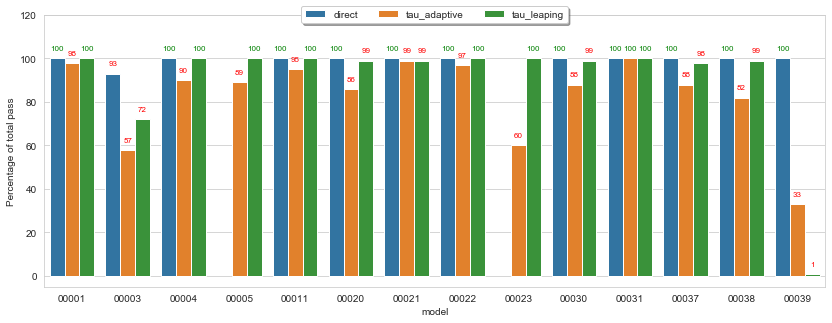

In [154]:
plot_pass_bars(results[results.lib == "pyssa"])

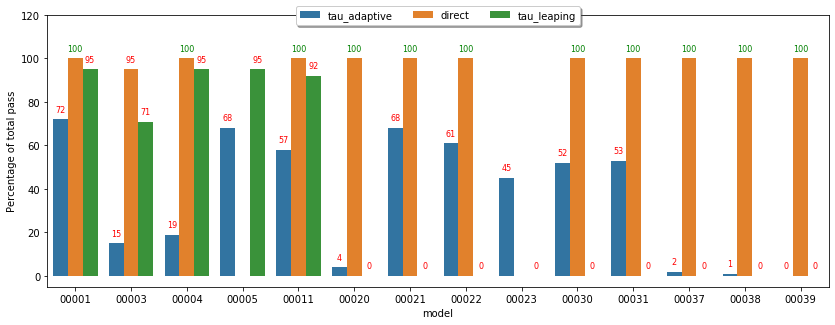

In [33]:
plot_pass_bars(results[results.lib == "BioSimulator"])

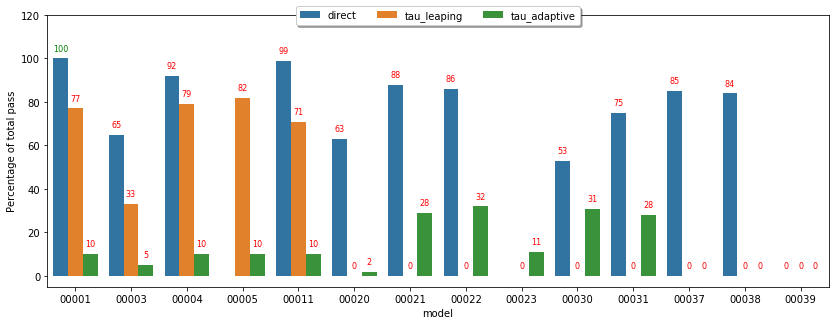

In [34]:
plot_pass_bars(results[results.lib == "BioSimulatorIntp"])

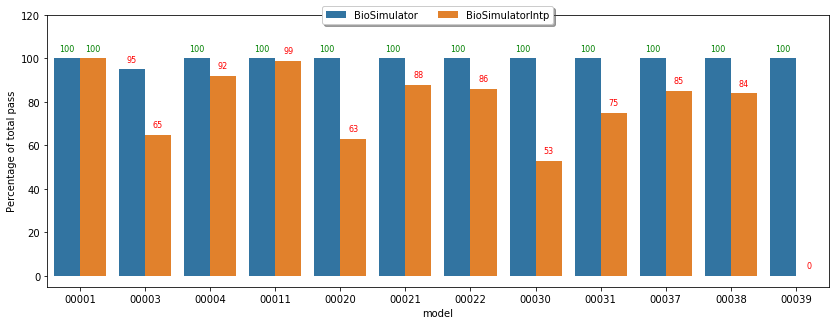

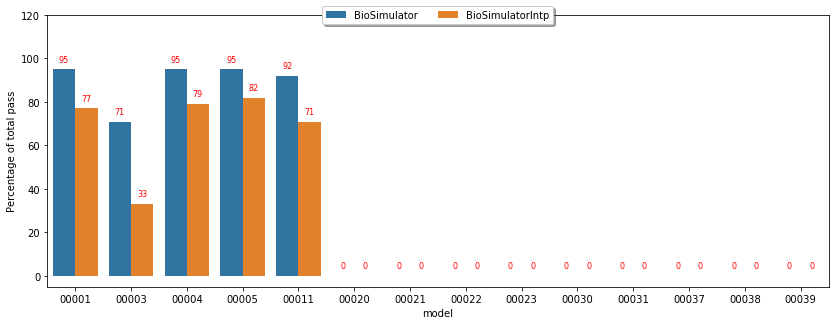

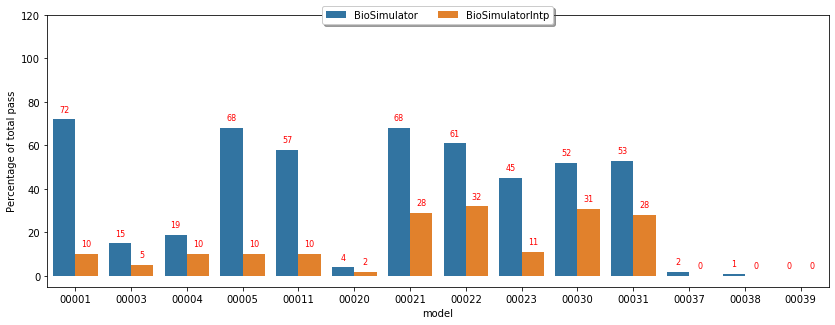

In [35]:
plot_pass_bars(results[((results.lib == "BioSimulatorIntp") | (results.lib == "BioSimulator")) & (results.algo == "direct")], hue="lib")
plot_pass_bars(results[((results.lib == "BioSimulatorIntp") | (results.lib == "BioSimulator")) & (results.algo == "tau_leaping")], hue="lib")
plot_pass_bars(results[((results.lib == "BioSimulatorIntp") | (results.lib == "BioSimulator")) & (results.algo == "tau_adaptive")], hue="lib")

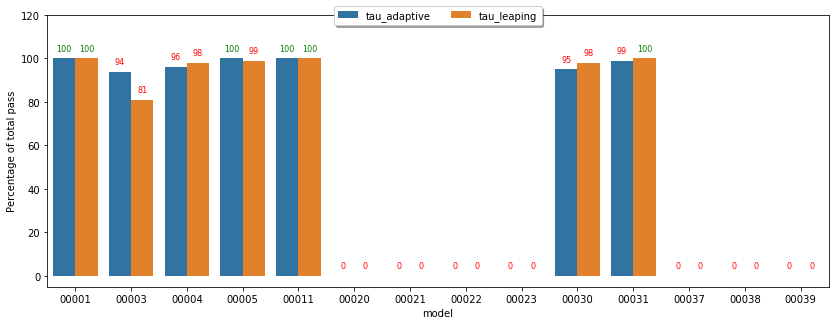

In [36]:
plot_pass_bars(results[results.lib == "GillespieSSA"]) # tau = 0.1

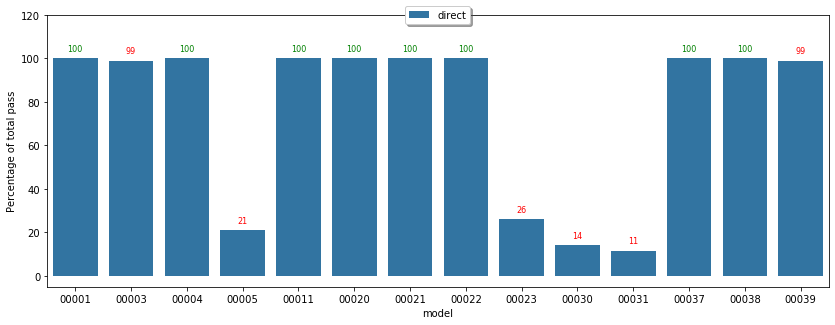

In [37]:
plot_pass_bars(results[results.lib == "Tellurium"])

# Direct

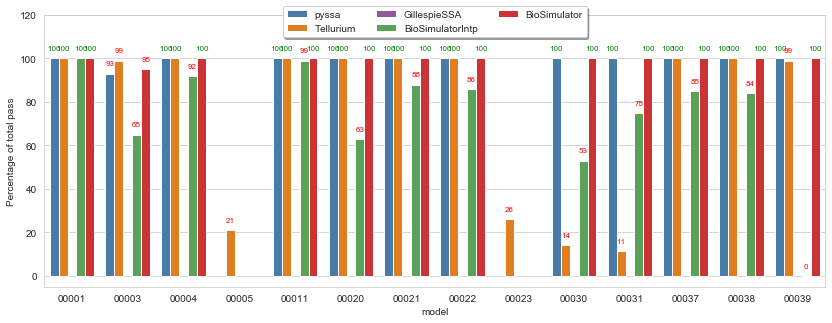

In [157]:
plot_pass_bars(results[results.algo == "direct"], hue="lib")

Model | Fail | Reason
---|---|---
00001 | No | n/a
00003 | Yes, all | Even the C library says it will fail
00004 | Yes, BioSimulatorIntp | BioSimulatorIntp (BioSimulator internal interpolation not accurate)
00005 | DNF, all | Tellurium is probably not doing direct
00011 | No | n/a (99 is okay) 
00020 | Yes, BioSimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00021 | Yes, BioSimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00022 | Yes, BioSimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00023 | DNF, all | Tellurium is probably not doing direct
00030 | Yes, Tellurium, BiosimulatorIntp | Tellurium fails even when rate expression is hardcoded as per `sbml-test-suite`. BiosimulatorIntp fails at high slope and low slope regions.
00031 | Yes, Tellurium, BiosimulatorIntp |  Tellurium fails even when rate expression is hardcoded as per `sbml-test-suite`. BiosimulatorIntp fails at high slope/quick change regions.
00037 | Yes, BiosimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00038 | Yes, BiosimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00039 | Yes, , BiosimulatorIntp | Fails completely because it returns an incorrect steady state.

# Tau leaping (update pending)

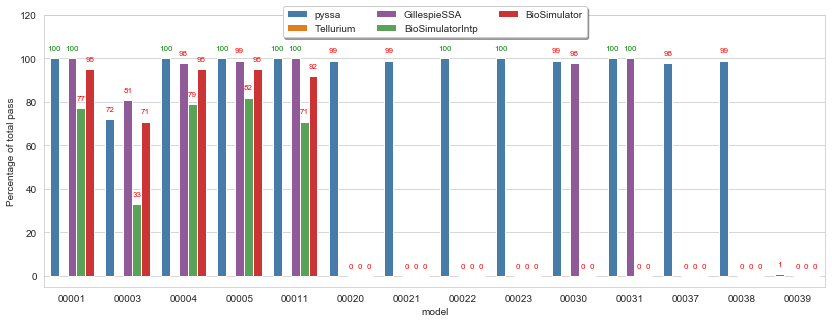

In [158]:
plot_pass_bars(results[results.algo == "tau_leaping"], hue="lib")

Model | Fail | Reason
---|---|---
00001 | No, BioSimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00003 | Yes, all | Even the C library says it will fail. BioSimulatorIntp is worse.
00004 | Yes, BioSimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00005 | Yes, BioSimulator, BioSimulatorIntp | Plots actually look pretty good, although they don't meet statistical standards. Mu ratio looks okay (for BioSimulator and
00011 | No | n/a
00020 | Yes, Biosimulator, BiosimulatorIntp and GillespieSSA | All fail because of 0 species. 
00021 | Yes, Biosimulator, BiosimulatorIntp and GillespieSSA | All fail because of 0 species. 
00022 | Yes, Biosimulator, BiosimulatorIntp and GillespieSSA  | All fail because of 0 species. 
00023 | Yes, all | GillespieSSA fails because of 0 species. `pyssa` fails initially, but then becomes accurate later on. BioSimulator fails all mean tests. Both pass SD.
00030 | Yes, all | ? - Biosimulator is inaccurate initially but comes accurate later (mean). SD is fine. Similar for `pyssa`. GillespieSSA fails all means, passes SD.
00031 | Yes, all | ? - Biosimulator is inaccurate initially but comes accurate later (mean). SD is fine. Similar for `pyssa`. GillespieSSA fails all means, passes SD.
00037 | Yes, GillespieSSA and Biosimulator | GillespieSSA fails because of 0 species. BioSimulator fails a little initially (mean+SD).
00038 | Yes, GillespieSSA and Biosimulator | GillespieSSA fails because of 0 species. BioSimulator fails a little initially (mean + SD).
00039 | Yes, all | GillespieSSA fails because of 0 species. `pyssa` fails, likely because of high tau. BioSimulator converges to the wrong mean value, but the model seems right (since it was copied and modified from 37,38 and those converge to correct value. Strangely BioSimulator SD converges)

# Tau adaptive (update table)

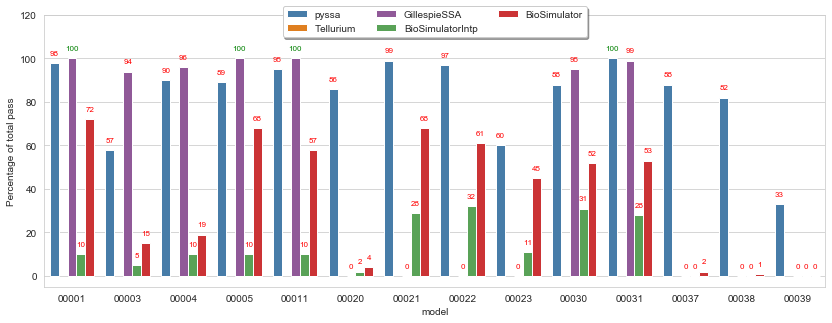

In [159]:
plot_pass_bars(results[results.algo == "tau_adaptive"], hue="lib")

Model | Fail | Reason
---|---|---
00001 | Yes, Biosimulator | ? - Look at plot
00003 | Yes, `pyssa` and Biosimulator | ? - Even the C library says it will fail, but look at plots
00004 | Yes, all | ? - Look at plot
00005 | Yes, pyssa and Biosimulator | plot Biosimulator, pyssa
00011 | Yes Biosimulator | ? plot Biosimulator
00020 | Yes, all | Gillespie fails because of 0 species. `pyssa` fails initially for small numbers (mean+SD), small numbers. Why BioSimulator?
00021 | Yes, all | Gillespie fails because of 0 species. `pyssa` fails initially for small numbers (only mean), small numbers. Why BioSimulator?
00022 | Yes, all | Gillespie fails because of 0 species. `pyssa` fails initially and somewhere in the middle (only mean), but small numbers initially and few small fails in the middle. Why BioSimulator?
00023 | Yes, all | GillespieSSA fails because of 0 species. `pyssa` a huge deviation in mean and SD, both small and large numbers. Why BioSimulator?
00030-00031 | Yes, all | ? - Look at all plots carefully, probably to do with wrong accuracy tests and model was also wrong. Why did GillespieSSA fail, **rerun** ? Check model
00037-00038 | Yes, all |? - Look at all plots. Why did GillespieSSA fail, **rerun** ? Check model
00039 | Yes, all | ? - Look at all plots. Why did GillespieSSA fail, **rerun** ? Check model